In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gender-submission-csv/gender_submission.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import numpy as np

# Load data
X_trainda = pd.read_csv('/kaggle/input/titanic/train.csv')
X_test = pd.read_csv('/kaggle/input/titanic/test.csv')

y = X_trainda.pop('Survived')

def extract_title(df):
    return df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
X_trainda['Title'] = extract_title(X_trainda)

# Function to distinguish categorical and numerical data
def distinguish_data_types(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
    return categorical_columns, numerical_columns
# Function to calculate family size
def calculate_family_size(df):
    return df['SibSp'] + df['Parch'] + 1
X_trainda['FamilySize'] = calculate_family_size(X_trainda)
X_test['FamilySize'] = calculate_family_size(X_test)
features_cat, features_num = distinguish_data_types(X_trainda)
features_cat.remove('Name')
X_trainda = X_trainda.drop(columns=['Name'])
features_num.remove('PassengerId')
X_trainda = X_trainda.drop(columns=['PassengerId'])
features_num.remove('Fare')
X_trainda = X_trainda.drop(columns=['Fare'])


print("Categorical columns:", features_cat)
print("Numerical columns:", features_num )
# Preprocessing pipelines
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0),  # Fill missing values with 0
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore', sparse=False),  # Ensure dense output
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# Stratified split of the data
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainda, y, stratify=y, train_size=0.75
)

# Transform the data
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

# Convert to float32 if not already
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')

input_shape = [X_train.shape[1]]


Categorical columns: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title']
Numerical columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'FamilySize']


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape,),  # BatchNormalization layer with input shape
    layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)),               # First Dense layer
    layers.BatchNormalization(),                        # BatchNormalization after first Dense layer
    layers.Dropout(0.3),                                # Dropout after first Dense layer
    layers.Dense(256, activation='relu',kernel_regularizer=l2(0.001)),               # Second Dense layer
    layers.BatchNormalization(),                        # BatchNormalization after second Dense layer
    layers.Dropout(0.3),                                # Dropout after second Dense layer
    layers.Dense(1, activation='sigmoid')               # Output layer with sigmoid activation for binary classification
])

2024-07-25 08:25:11.121649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 08:25:11.121796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 08:25:11.267245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - binary_accuracy: 0.5123 - loss: 1.5521 - val_binary_accuracy: 0.6771 - val_loss: 1.2857
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - binary_accuracy: 0.6312 - loss: 1.3077 - val_binary_accuracy: 0.6951 - val_loss: 1.2554
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - binary_accuracy: 0.7526 - loss: 1.1198 - val_binary_accuracy: 0.6996 - val_loss: 1.2284
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - binary_accuracy: 0.8181 - loss: 0.9853 - val_binary_accuracy: 0.6771 - val_loss: 1.2061
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - binary_accuracy: 0.8686 - loss: 0.9025 - val_binary_accuracy: 0.6726 - val_loss: 1.1877
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.8762 - loss: 0.8596 - val_binary_accuracy: 0.6726 - val_loss: 1.1717
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - binary_accuracy: 0.9409 - loss: 0.7852 - val_binary_accuracy: 0.6592 - val_loss: 1.1575
Epoch 8/200
2/2 ━━━

<Axes: title={'center': 'Accuracy'}>

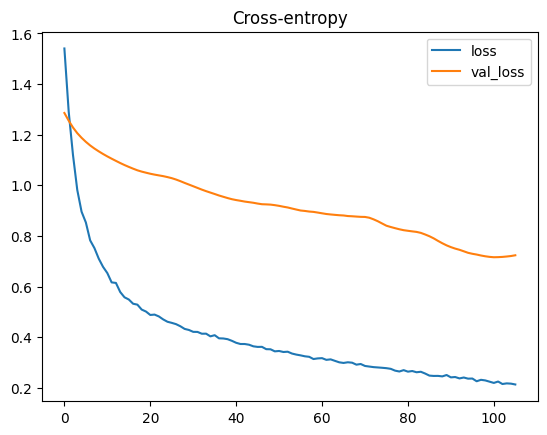

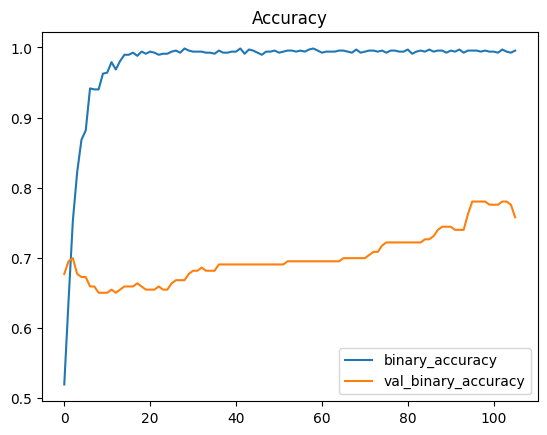

In [5]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Load the test data
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Extract PassengerId for the submission
passenger_ids = test_df['PassengerId']
test_df['FamilySize'] = calculate_family_size(test_df)
test_df['Title'] = extract_title(test_df)
# Ensure the test set has the correct columns before transformation
# The columns used in training need to be present in the test set.
required_columns = ['Pclass', 'Age', 'FamilySize', 'Fare', 'Sex', 'Embarked']

# Handle missing columns that might not be in the test set
for col in required_columns:
    if col not in test_df.columns:
        # If a column is missing, you can add it with a default value
        if col in ['Age', 'Fare']:
            test_df[col] = np.nan  # You can choose a default value or keep NaN for imputation
        else:
            test_df[col] = 'missing'  # Placeholder for categorical missing values

# Ensure the test set matches the training set's features
# Use the same transformations as applied to the training data
test_df_transformed = preprocessor.transform(test_df)  # Using the preprocessor from the training phase

# Convert the test data to float32 as required by the model
test_df_transformed = test_df_transformed.astype('float32')

# Make predictions
predictions = model.predict(test_df_transformed)

# Convert predictions to class labels
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1

# Create a DataFrame with the submission data
submission_df = pd.DataFrame({
    'PassengerId': passenger_ids,  # Ensure these match the test set order
    'Survived': predicted_labels
})

# Save the DataFrame to a CSV file
submission_file = 'submission.csv'
submission_df.to_csv(submission_file, index=False)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
